# Regularisation with Tensorflow

Previously, we have seen how to build in Tensorflow an end-to-end workflow
for training, evaluating and predicting from
deep learning models. Now we are
going to look at adding some important features.  
We will look
at how we can include held out validation sets
in training, as well as implementing regularization techniques
such as weight decay, dropout, and early stopping.  
We will see
the callbacks, which are really useful
objects that help to perform functions during training and evaluation runs. You can use callbacks
for example to monitor the model's performance on a
held out a validation set and terminate the
training run according to some criteria.  
Just as in the previous post, we apply these concepts 
in a deep learning model, this time for the diabetes 
dataset. 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


## Load and pre-process the data

The diabetes dataset is available directly from SKlearn:

In [2]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

In [3]:
diabetes_datasets = load_diabetes()
print(diabetes_datasets["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [4]:
# Save the input and target variables

print(diabetes_datasets.keys())

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [5]:
data = diabetes_datasets["data"]
targets = diabetes_datasets["target"]

In [6]:
# The ten features are already normalised.
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean(axis = 0)) / targets.std()

### Split the data into train and test sets

In [27]:
import numpy as np

# for reproducibility

np.random.seed(8)
tf.random.set_seed(8)

In [28]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size = 0.1)

print (train_data.shape)
print (test_data.shape)
print (train_targets.shape)
print (test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


In [29]:
# example of train data
train_data[0]

array([-0.02367725, -0.04464164, -0.046085  , -0.03321358,  0.03282986,
        0.03626394,  0.03759519, -0.00259226, -0.03324879,  0.01134862])

In [30]:
# example of train target

train_targets[0]

-1.0406169469320903

## First model: Train a feedforward neural network model

In Deep Learning there are no hard & fast rules to set the number of layers, the number of hidden units per layer and not even the kind of connections between layers.  
It is a lot about try and improve.  
We start with a "simple" sequential model with 6 layers plus one output layer...

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [32]:
# Build the model

firstModel = Sequential([
        Dense(128, activation = "relu", input_shape=(train_data.shape[1],)),
        Dense(128, activation = "relu"), 
        Dense(128, activation = "relu"), 
        Dense(128, activation = "relu"), 
        Dense(128, activation = "relu"), 
        Dense(128, activation = "relu"), 
        Dense(1) 
    ])

In [33]:
# Print the model summary

firstModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

### Compile and train the first unregularised model
We are compiling the model
with the Adam optimizer, a mean squared error loss and we have chosen mean absolute percentage error
as a performance metric (the target is a float, not a class).

In [34]:
# Compile the model: optimiser is Adam, we measure the loss and the Mean Abosulte Error as accuracy

firstModel.compile(optimizer = "adam", loss="mse", metrics=["mae"])

Let's say then that we want
to track the performance of our model on a separate
held-out validation set. One way we can do
this is to pass in **the validation split
keyword** argument. What this does is to
automatically split the inputs in the targets into separate training
and validation sets.  
The 0.15 you see here means that 15 percent of the data will
be held back for validation. The model's performance
is then recorded on both the training
and validation sets.  
It is also possible to use the validation
data keyword argument in the fit function if you have already a separate validation set (or you can build it tyourself using the sklearn split functon, as done above for the test dataset). 

In [35]:
# Train the model, with some of the data reserved for validation (15%)

firstTrainingHistory = firstModel.fit(train_data, train_targets, epochs = 100, validation_split = 0.15, 
                    batch_size = 64, verbose = False)

In the previous post we have seen that the *model.fit* method returns the
history object and it records the training set loss and metrics over the course
of the model training; now this history object also records the performance
on the validation set.   
If we were to take a
look at this dictionary, would see that it
now not only has keys for the training set
loss and metric values, but also for the validation
loss of metric values. 

In [36]:
firstTrainingHistory.history['loss'][0]

1.0174599868253713

In [37]:
firstTrainingHistory.history['val_loss'][0]

0.8934926390647888

### Evaluate the model on the test set

In [38]:
lossU, maeU = firstModel.evaluate(test_data, test_targets, verbose=False)
print(f"Loss is {lossU}\nMAE is {maeU}")

Loss is 0.6796898722648621
MAE is 0.6636810302734375


**Loss = 0.68**  
The loss on the test set is quite high  !

We can get more details on the training by plotting the curves.  
### Plot the learning curves

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

In [40]:
def plotMetricsByEpoch(history):
    frame = pd.DataFrame(history)
    epochs = np.arange(len(frame))

    fig = plt.figure(figsize=(12,4))

# Loss plot
    ax = fig.add_subplot(121)
    ax.plot(epochs, frame['loss'], label="Train")
    ax.plot(epochs, frame['val_loss'], label="Validation")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("Loss vs Epochs")
    ax.legend()

# Accuracy plot
    ax = fig.add_subplot(122)
    ax.plot(epochs, frame['mae'], label="Train")
    ax.plot(epochs, frame['val_mae'], label="Validation")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Mean Absolute Error")
    ax.set_title("Accuracy: Mean Absolute Error vs Epochs")
    ax.legend();

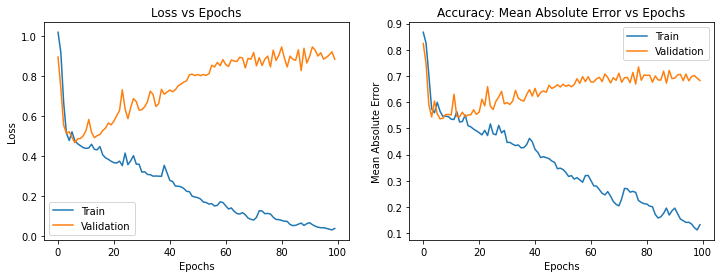

In [41]:
plotMetricsByEpoch(firstTrainingHistory.history)

One interesting outcome from the curves is that the **metrics on the validation dataset** (the orange one) **is not improving** at all after the first epochs. It even diverges.   
A clear sign of **overfitting**. Let's regularise!

## Model regularisation

In order to improve the performance of the model, we use different regularization techniques. There are several techniques, but we will discuss these main techniques:

- L1/L2 Regularization
- Dropout
- Batch Normalization
- Early Stopping

### Adding regularisation with weight decay

We start to look at using **L2 weight regularization**, which is also known
as weight decay in a context of neural networks.  
Dense layers as well as
convolutional layers have an optional *kernel_regularizer* keyword argument to add in weights decay
or L1 regularization. We set the kernel
regularizer argument equal to
*tf.keras.regularizes.L2 object*. This object is created with
one required arguments, which is the coefficient
that multiplies the sum of squared
weights in this layer.  
Remember that a dense layer
has weights and biases, and the weight matrix is
sometimes called the kernel. Here we set the weight
decay coefficients to be equal to 0.00001. Once we've built the model together with the weight decay, we can compile and fit
the model as normal.  
The weight decay penalty
term is automatically added to the loss-function
when we compile the model.  
This sum of squared
weights term has the effect of **penalizing
large values of the weights, which encourages
the model to find the simpler function
that fits the data**. This means the model is less likely to overfit to
the training set.  
  
We can use L1 regularization
in a very similar way(L1 regularization has the effect of pacifying the network weights. Or in other words, it results in some of those weights
being set to zero). In fact, there's no reason
why you couldn't use both L1 and L2 regularization, there is a *tf.keras.regularizers.l1l2* object, and pass that to the kernel
regularizer argument.  
It's quite typical to 
apply regularization to the weight matrix or the kernel of a dense
or convolutional layer.

In [42]:
from tensorflow.keras import regularizers

In [43]:
# we define a model that is the same as the previous one, only regularised
# wd is the weight decay
wd = 1e-5

regularisedModel = Sequential([
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dense(1)])


In [44]:
# Compile the model

regularisedModel.compile(optmizer="adam", loss="mse", metrics=["mae"])

# Train the model, with some of the data reserved for validation

trainingHistoryR1 = regularisedModel.fit(train_data, train_targets, epochs = 100,
                   validation_split = 0.15, batch_size = 64, verbose=False)

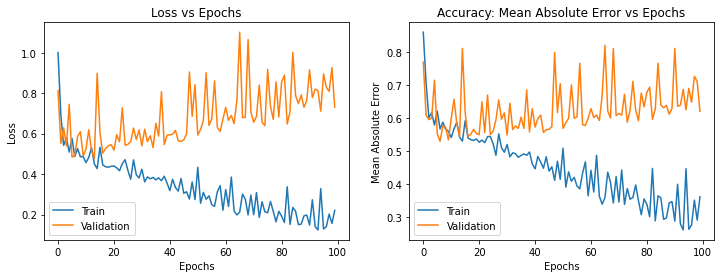

In [45]:
plotMetricsByEpoch(trainingHistoryR1.history)

In [46]:
# Evaluate the model on the test set

lossR1, maeR1 = regularisedModel.evaluate(test_data, test_targets, verbose=False)
print(f"Loss is {lossR1}\nMAE is {maeR1}")

Loss is 0.5570601211653815
MAE is 0.5728724002838135


The loss improved to 0.55 but the results on the validation dataset shows it's still overfitting.     
  
Another common way to avoid regularization is by using **the Dropout technique**. The main idea behind using dropout is that we **randomly turn off some neurons** in our layer based on some probability.  
  
In order to implement DropOut, all we have to do is to add a Dropout layer from *tf.keras.layers* and set a dropout rate in it.  
  
The Dropouts layer has
a required arguments, which is the Dropouts rate. Here the rate has been set to 0.3 and that means that
each weight connection between these two dense layers is set to zero with probability 0.3  
Each of the weights are
randomly dropped out independently from
one another and Dropout has also
applied independently across each element in the
batch at training time. Again, we can compile and
fit our model as normal, with Dropouts layers
included in the model.  
When we're using Dropouts, we typically have
two different modes for how we run the network. At training time, we randomly Dropout
weights and we can think
of this as Training mode. However, when we're evaluating our model or making
predictions from it, we stopped randomly
dropping out the weights and we can think of
this as testing mode. These two modes are automatically handled behind the
scenes by the *model.fit, .evaluate, and .predict* methods.

In [47]:
from tensorflow.keras.layers import Dropout


In [48]:
# we define a function to build a regularised model that we can call later to tune the parameters
# (weight D ... and dropout rate)

def getRegularisedModel(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [49]:
regularisedModelD = getRegularisedModel(1e-5, 0.3)

In [50]:
# Compile the model

regularisedModelD.compile(optmizer="adam", loss="mse", metrics=["mae"])

In [51]:
# Train the model, with some of the data reserved for validation

trainingHistoryR2 = regularisedModelD.fit(train_data, train_targets, epochs = 100,
                   validation_split = 0.15, batch_size = 64, verbose=False)

In [52]:
# Evaluate the model on the test set

lossR2, maeR2 = regularisedModelD.evaluate(test_data, test_targets, verbose=False)
print(f"Loss is {lossR2}\nMAE is {maeR2}")

Loss is 0.44559474521213105
MAE is 0.5283032059669495


**Loss = 0.45**  
Loss improved quite a lot and we can see it also in the plots, now the results on the validation dataset are much more similar to the ones on the train dataset:

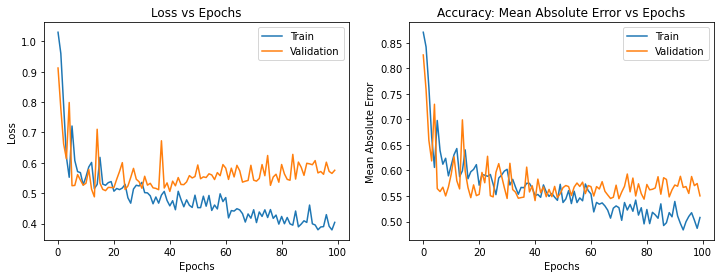

In [53]:
# Plot the training and validation loss

plotMetricsByEpoch(trainingHistoryR2.history)

Validation now is much more similar to training and improved during the epochs

We are looking at another regularisation technique: the batch normalisation.

# Batch normalisation layers

Now we will look at incorporating batch normalisation into our models.  

The main idea behind batch normalization is that we normalize the input layer by using several techniques as we did in the data pre-processing section, which improves the model performance. So - if the input layer is benefitted by normalisation - why not **normalise the hidden layers**, which will improve and fasten learning even further?
  
The original (2015) paper motivated introduction of the layers by stating that these layers help fixing "internal covariate shift". The rough idea is that large shifts in the distributions of inputs of inner layers makes training less stable, leading to decrease in the learning rate and slowing down of the training. Batch normalisation mitigates this problem by standardising the inputs of inner layers.  
>In traditional deep networks, too-high learning rate may result in the gradients that explode or vanish, 
(known as the **vanishing or exploding gradient problem**)as well as getting stuck in poor local minima.   
> Batch Normalization helps address these issues. By normalizing activations throughout the network, it prevents small changes to the parameters from amplifying into larger and suboptimal changes in activations in gradients  
  
Although this is still debated; more recent papers state that it works more for other reasons like the "key benefit" being the fact that Batch Normalization biases residual blocks towards the identity function.

To add it in your TensorFlow model, just add *tf.keras.layers.BatchNormalization()* after your layers (one, some or all).
Adding BatchNorm layers improves training time and makes the whole deep model more stable. That's an experimental fact that is widely used in machine learning practice.

In [54]:
from tensorflow.keras.layers import BatchNormalization

In [55]:
wd = 1e-8
rate = 0.2

modelBN = Sequential([
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
])


There are some parameters and hyperparameters associated with batch normalisation:

* The hyperparameter **momentum** is the weighting given to the previous running mean when re-computing it with an extra minibatch. By **default**, it is set to 0.99.

* The hyperparameter **$\epsilon$** is used for numeric stability when performing the normalisation over the minibatch. By **default** it is set to 0.001.

* The parameters **$\beta$** and **$\gamma$** are used to implement an affine transformation after normalisation. By **default**, $\beta$ is an all-zeros vector, and $\gamma$ is an all-ones vector.

### Customising parameters
These can all be changed (along with various other properties) by adding optional arguments to `tf.keras.layers.BatchNormalization()`.

We can also specify the axis for batch normalisation. By default, it is set as -1.

Let's see an example.

In [56]:
# Add a customised batch normalisation layer

modelBN.add(BatchNormalization(
    momentum=0.95, 
    epsilon=0.005,
    axis = -1,
    beta_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
    gamma_initializer= tf.keras.initializers.Constant(value=0.9)
))

In [57]:
# Add the output layer

modelBN.add(Dense(1))

In [58]:
# Print the model summary

modelBN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 128)               1408      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)              

Let's now compile and fit our model with batch normalisation, and track the progress on training and validation sets.

In [59]:
# Compile the model

modelBN.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

In [60]:
# Train the model

trainingHistoryBN = modelBN.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64,
                                verbose=False)

In [61]:
# Evaluate the model on the test set

lossBN, maeBN = modelBN.evaluate(test_data, test_targets, verbose=False)
print(f"Loss is {lossBN}\nMAE is {maeBN}")

Loss is 0.4684510456191169
MAE is 0.554763913154602


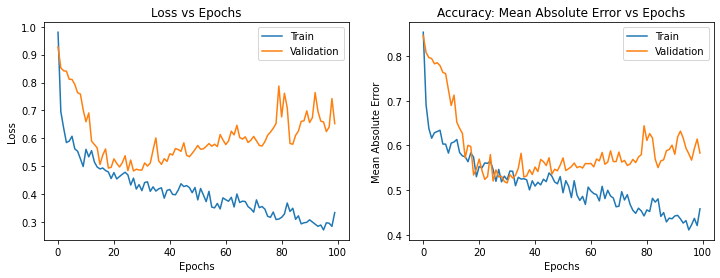

In [62]:
# Plot the training and validation loss

plotMetricsByEpoch(trainingHistoryBN.history)

Batch normalisation can be applied to all layers, not only before the last one, and this usually improves the performance:

In [69]:
modelBN2 = Sequential([
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        BatchNormalization(),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        BatchNormalization(),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        BatchNormalization(),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        BatchNormalization(),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        BatchNormalization(),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        BatchNormalization(
            momentum=0.95, 
            epsilon=0.005,
            beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
            gamma_initializer=Constant(value=0.9)),
        Dense(1)
])

In [70]:
# Compile the model

modelBN2.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

In [71]:
# Train the model

trainingHistoryBN2 = modelBN2.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64,
                                verbose=False)

In [72]:
# Evaluate the model on the test set

lossBN2, maeBN2 = modelBN2.evaluate(test_data, test_targets, verbose=False)
print(f"Loss is {lossBN2}\nMAE is {maeBN2}")

Loss is 0.5313854575157165
MAE is 0.5935487747192383


#### Plot the learning curves

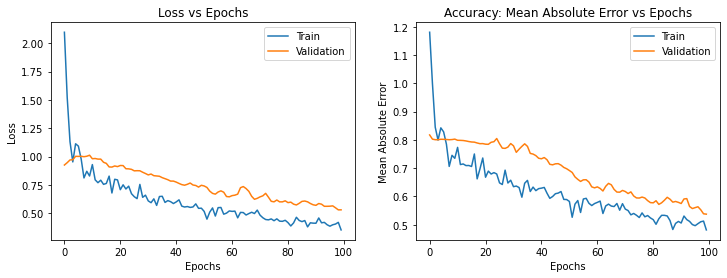

In [73]:
# Plot the training and validation loss

plotMetricsByEpoch(trainingHistoryBN2.history)

## Introduction to callbacks
  
But even now we're monitoring the performance of our model
on the validation set, we're still having to fix
the number of epochs that the model is training
for ahead of time. What we would like
to do is to have the ability to not only monitor the performance
of the network, but also perform certain actions depending on those
performance measures.   
That's where callbacks come in. Callbacks are an
important type of object TensorFlow and Keras that
are exactly designed to be able to monitor the loss in metrics at certain points in
the training run and perform some
action.  
In TensorFlow, all callbacks are stored in the *tensorflow.keras.callbacks*
module. Inside that module, there's
a base class called *callback* which all other
callbacks inherit from. You can also subclass
the callback based class yourself to create
your own callbacks.  
For example, one
of the methods of the callback base class
is called *on_train_begin*.  
So we can override this method in our new callback to perform some action at the beginning
of the training run. Similarly, there
are more methods of the base class that are called at other points in the training, for example after each Epoch. 

#### Example training callback

In [74]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print("Starting Training ...")

            # Print the loss and mean absolute error after each epoch
    def on_epoch_end(self, epoch, logs=None):
        print('Epoch {}: Average loss is {:7.2f}, mean absolute error is {:7.2f}.'.format(epoch, logs['loss'], logs['mae']))
    
    def on_train_end(self, logs=None):
        print("Finished training!")
        

In [75]:
# Train the model, with some of the data reserved for validation

regularisedModel.fit(train_data, train_targets, epochs = 3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])

Starting Training ...
Epoch 0: Average loss is    0.22, mean absolute error is    0.32.
Epoch 1: Average loss is    0.21, mean absolute error is    0.34.
Epoch 2: Average loss is    0.20, mean absolute error is    0.31.
Finished training!


You can see that *on_epoch_end* has been overwritten to print the current loss and accuracy, after the end of the epoch.  
The argument *callbacks* is a list because
in practice you might be passing in a
number of callbacks, all of which are performing different tasks during
the training run.
  
Remember that *model.fit* 
returns a history object. That object is actually an example
of a callback. It's a callback that is
automatically included into every training run
whenever we call *model.fit*. The action that
this callback takes is simply to record the loss and metric values and store them as a dictionary in its
history attribute.

We can actually also
use callbacks in evaluation and
prediction runs as well:

In [76]:
# Write more custom callbacks

        
class LossAndMetricCallback(Callback):
    
    def on_test_begin(self, logs=None):
        print("Starting Testing ...")
        
    # Print the loss after each batch in the test set
    def on_test_batch_end(self, batch, logs=None):
        print('\n After batch {}, the loss is {:7.2f}.'.format(batch, logs['loss']))
        
    def on_test_end(self, logs=None):
        print("Finished testing!")
            
    def on_predict_begin(self, logs=None):
        print("Starting prediction ...")
        
            # Notify the user when prediction has finished on each batch
    def on_predict_batch_end(self,batch, logs=None):
        print("Finished prediction on batch {}!".format(batch))
              
              
    def on_predict_end(self, logs=None):
        print("Finished Prediction!")

In [77]:
# Evaluate the model

regularisedModel.evaluate(test_data, test_targets, verbose=False, callbacks=[LossAndMetricCallback()])

Starting Testing ...

 After batch 0, the loss is    0.56.

 After batch 1, the loss is    0.87.
Finished testing!


[0.6517713652716742, 0.63849205]

In [78]:
# Make predictions with the model

regularisedModel.predict(test_data, verbose=False, callbacks=[LossAndMetricCallback()])

Starting prediction ...
Finished prediction on batch 0!
Finished prediction on batch 1!
Finished Prediction!


array([[ 1.67871070e+00],
       [ 4.79987055e-01],
       [ 4.81804490e-01],
       [-5.43541551e-01],
       [ 6.77228868e-01],
       [ 3.89715940e-01],
       [-1.83921322e-01],
       [ 8.65635693e-01],
       [-1.20444342e-01],
       [ 2.95485724e-02],
       [ 7.96585143e-01],
       [ 1.06385583e-03],
       [-1.41053215e-01],
       [-6.30565107e-01],
       [ 5.39242387e-01],
       [ 2.88824469e-01],
       [ 5.36303222e-01],
       [-6.54762983e-01],
       [ 7.43690372e-01],
       [ 4.28688437e-01],
       [ 1.06151283e+00],
       [ 3.61632347e-01],
       [ 2.98363596e-01],
       [-2.56275743e-01],
       [ 4.17451322e-01],
       [ 1.79567888e-01],
       [-3.07317436e-01],
       [ 2.87642121e-01],
       [ 3.53769869e-01],
       [-7.43298054e-01],
       [ 1.36662626e+00],
       [ 8.01936924e-01],
       [ 5.34957230e-01],
       [ 1.24834105e-01],
       [-5.44094801e-01],
       [ 1.21964002e+00],
       [-2.55104214e-01],
       [ 7.19600976e-01],
       [ 1.7

There are quite a few
built-in callbacks in TensorFlow and you can take a look at the list of built-in callbacks, if you go to the API
documentation on TensorFlow.org.

These actions above are simple and just serve to demonstrate
how to use callbacks, but we'll soon be
using callbacks for several important aspects
of our model chain.

## Early stopping / patience

Early stopping is
a technique that monitors the performance
of the network for every epoch on a
held out validation set during the training run, and terminates the training based on the
validation performance.  
The Keras module contains
a built-in callback designed for this purpose called the early
stopping cutback.  
So what the early stopping
callback is doing, is monitoring the performance of the network on the
validation set and stopping the training depending on how that performance
progresses.  
  
A natural question is, which measure of performance
is the callback monitoring? The early stopping
callback constructor takes a keyword argument
called *monitor*, which can be used to set which
performance metric to use.  
The default setting for the early
stopping callback is the validation loss, which equals to pass in *val_loss*.   
You can
instead choose to use the validation accuracy as the performance measure to decide when to terminate the training.  
Another keyword
arguments that we can set in the early
stopping callback is the *patience* argument. By default, patience
is set to zero. That means that as soon as
the performance measure gets worse from one
epoch to the next, then the training is terminated. Now, this might not be
ideal since of course, the model's performance is noisy, and it might go up or down
from one epoch to the next. What we really care about is that the general trend
should be improving. That's why will often set the patience to some
number of epochs.  
In this case, the training
will terminate only if there is no improvement in the monitor performance measure, the n epochs, in a row.  
  
The early stopping callback also has a *min_delta* argument. This option can be
used to define what qualifies as an improvement in the monitor
performance measure. For example, 0.01  means that the
validation accuracy has to improve by at least 0.01 for it to
count as an improvement. If the validation
accuracy improved by a smaller amount, say by 0.005, then that would be
treated the same as a worsening of the performance by the early stopping callback and the patients counter
would increase by one. By default, *min_delta* is zero, which means that
any improvement in the performance is enough
to reset the patience.

### Re-train the regularised model with early stopping

In [110]:
from tensorflow.keras.callbacks import EarlyStopping

In [80]:
# Re-train the regularised model

regularisedModelES = getRegularisedModel(1e-8, 0.2)
regularisedModelES.compile(optimizer="adam", loss="mse",  metrics=["mae"])
reg_history = regularisedModelES.fit(train_data, train_targets, epochs=100,
                                       validation_split=0.15, batch_size=64, verbose=False,
                                       callbacks= [EarlyStopping(patience=3)])

In [81]:
# Evaluate the model on the test set

lossR2, maeR2 = regularisedModelES.evaluate(test_data, test_targets, verbose=False)
print(f"Loss is {lossR2}\nMAE is {maeR2}")

Loss is 0.517778652244144
MAE is 0.6009424924850464


#### Plot the learning curves

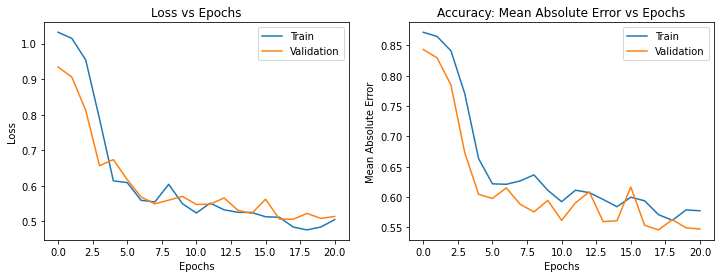

In [82]:
# Plot the training and validation loss

plotMetricsByEpoch(reg_history.history)

You can see that the model stopped training after 20 epochs (that's a fifth of the original one!) because the error on training wasn't improving anymore.  
You can also apply the early stopping by measuring the MAE on the validation dataset:

In [99]:
# Re-train the regularised model

regularisedModelES = getRegularisedModel(1e-8, 0.2)

regularisedModelES.compile(optimizer="adam", loss="mse",  metrics=["mae"])
reg_history = regularisedModelES.fit(train_data, train_targets, epochs=100,
                                       validation_split=0.15, batch_size=64, verbose=False,
                                       callbacks= [EarlyStopping(monitor='val_mae', patience=3)])

In [100]:
# Evaluate the model on the test set

lossR2, maeR2 = regularisedModelES.evaluate(test_data, test_targets, verbose=False)
print(f"Loss is {lossR2}\nMAE is {maeR2}")

Loss is 0.4972989757855733
MAE is 0.5870227217674255


#### Plot the learning curves

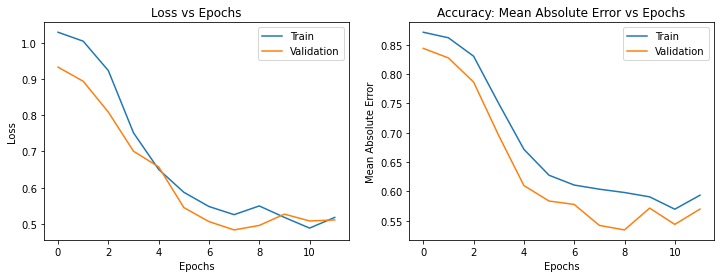

In [101]:
# Plot the training and validation loss

plotMetricsByEpoch(reg_history.history)

The process of setting the hyper-parameters requires expertise and extensive trial and error. There are no simple and easy ways to set hyper-parameters — specifically, learning rate, batch size, momentum, and weight decay.
  
Before discussing the ways to find the optimal hyper-parameters, let us first understand learning rate, batch size, momentum and weight decay. These hyper-parameters act as knobs which can be tweaked during the training of the model. For our model to provide best result, we need to find the optimal value of these hyper-parameters.
  
If the learning rate (LR) is too small, overfitting can occur. Large learning rates help to regularize the training but if the learning rate is too large, the training will diverge.
  
Batch size must be examined in conjunction with the execution time of the training. The batch size is limited by your hardware’s memory. 
It is often better to use a larger batch size so a larger learning rate can be used.
  
Weight decay is one form of regularization and it plays an important role in training so its value needs to be set properly.  
If you have no idea of a reasonable value for weight decay, test 1/10³ , 1/10⁴ , 1/10⁵ and 0.
  
Test with short runs of momentum values 0.99, 0.97, 0.95, and 0.9 to get the best value for momentum.

### Application - learning rate scheduler
Let's now look at a more sophisticated custom callback. 
  
We are going to define a callback to change the learning rate of the optimiser of a model during training. We will do this by specifying the epochs and new learning rates where we would like it to be changed.
  
First we define the auxillary function that returns the learning rate for each epoch based on our schedule.

In [102]:
# Define the learning rate schedule. The tuples below are (start_epoch, new_learning_rate)

lr_schedule = [
    (0, 0.01), (4, 0.007), (7, 0.005), (11, 0.003), (15, 0.001)
]

def get_new_epoch_lr(epoch, lr):
    # Checks to see if the input epoch is listed in the learning rate schedule 
    # and if so, returns index in lr_schedule
    epoch_in_sched = [i for i in range(len(lr_schedule)) if lr_schedule[i][0]==int(epoch)]
    if len(epoch_in_sched)>0:
        # If it is, return the learning rate corresponding to the epoch
        return lr_schedule[epoch_in_sched[0]][1]
    else:
        # Otherwise, return the existing learning rate
        return lr

In [103]:
# Define the custom callback

class LRScheduler(tf.keras.callbacks.Callback):
    
    def __init__(self, new_lr):
        super(LRScheduler, self).__init__()
        # Add the new learning rate function to our callback
        self.new_lr = new_lr

    def on_epoch_begin(self, epoch, logs=None):
        # Make sure that the optimizer we have chosen has a learning rate, and raise an error if not
        if not hasattr(self.model.optimizer, 'lr'):
              raise ValueError('Error: Optimizer does not have a learning rate.')
                
        # Get the current learning rate
        curr_rate = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        
        # Call the auxillary function to get the scheduled learning rate for the current epoch
        scheduled_rate = self.new_lr(epoch, curr_rate)

        # Set the learning rate to the scheduled learning rate
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_rate)
        print('Learning rate for epoch {} is {:7.3f}'.format(epoch, scheduled_rate))

We can apply the callback to the regularised model and see how the learning rate parameter gets adapted.

In [104]:
regularisedModelLR = getRegularisedModel(1e-8, 0.2)

In [105]:
# Print the model summary

regularisedModelLR.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 128)               1408      
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_36 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 128)             

In [106]:
# Compile the model

regularisedModelLR.compile(optimizer = "adam", loss="mse", metrics=["mae"])

In [107]:
# Fit the model with our learning rate scheduler callback

new_history = regularisedModelLR.fit(train_data, train_targets, epochs=20,
                            validation_split=0.15, batch_size=64, callbacks=[LRScheduler(get_new_epoch_lr)], verbose=False)

Learning rate for epoch 0 is   0.010
Learning rate for epoch 1 is   0.010
Learning rate for epoch 2 is   0.010
Learning rate for epoch 3 is   0.010
Learning rate for epoch 4 is   0.007
Learning rate for epoch 5 is   0.007
Learning rate for epoch 6 is   0.007
Learning rate for epoch 7 is   0.005
Learning rate for epoch 8 is   0.005
Learning rate for epoch 9 is   0.005
Learning rate for epoch 10 is   0.005
Learning rate for epoch 11 is   0.003
Learning rate for epoch 12 is   0.003
Learning rate for epoch 13 is   0.003
Learning rate for epoch 14 is   0.003
Learning rate for epoch 15 is   0.001
Learning rate for epoch 16 is   0.001
Learning rate for epoch 17 is   0.001
Learning rate for epoch 18 is   0.001
Learning rate for epoch 19 is   0.001


You can see that the learning rate was constantly adapted and diminished.

In [108]:
# Evaluate the model on the test set

lossULT, maeULT = regularisedModelLR.evaluate(test_data, test_targets, verbose=False)
print(f"Loss is {lossULT}\nMAE is {maeULT}")

Loss is 0.4649222453435262
MAE is 0.559996485710144


#### Plot the learning curves

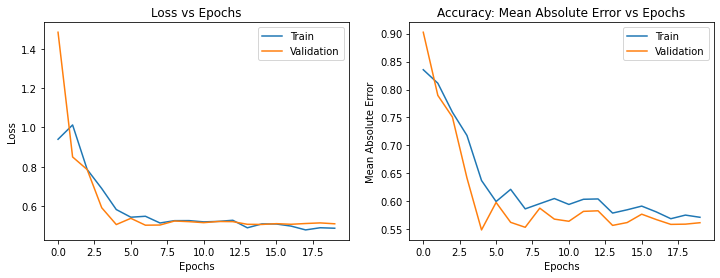

In [109]:
# Plot the training and validation loss

plotMetricsByEpoch(new_history.history)

Finally, one word that these methods are still open research, for example a new technique called [**adaptive gradient** from DeepMind researchers](https://arxiv.org/abs/2102.06171) meant to train networks without batch normalization, a widely-used technique that the authors want to get rid of because it's a bit fiddly.  

A well specified model pipeline — a model architecture, hyperparameters, training and test sets, and training procedure — should produce models that behave consistently. In practice, though, the same pipeline can produce many distinct models that achieve near-optimal performance, only some of which generalize to real-world conditions. Building a plethora of models and testing each one is the only way to know which is which.
But how can we specify model pipelines to produce consistent models? This is also an area where further studies are needed.